In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('../../../../')
print(os.getcwd())
from v2.strategy.indicators.optimal_v2 import Optimal_v2
from v2.model import Trading
from v2.strategy.indicators.param import Param
from v2.strategy.indicators.notebook_utils import fetchIndicators, genDataForAll
from load_config import load_config
from v2.strategy.indicators.momentum import Momentum
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from xgboost import XGBClassifier

/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
#adding in indicators
model = Trading(load_config("config.hjson"))
dataset_list = []

for list_d, name in model.df_groups:
    inter_df_list = []
    print(name)
    for d in list_d:
        now = time.time()
        cur_dataset = d
        my_inds = fetchIndicators(['stochastic_oscillator', 'variance','rsi', 'cci', 'ema', 'psar', 'beta', 'natr', 'macd', 'sma', 'smma', 'optimal_v2'])
        genDataForAll(cur_dataset, my_inds)
        mom_ind = Momentum(_params=[Param(2, 1000, 0, 'period', 15)])
        mom_ind.genData(cur_dataset, gen_new_values=False)
        cur_dataset.dropna(inplace=True)
        mm_scalar = MinMaxScaler()
        # cur_dataset[["rsi", "stosc_k", "stosc_d"]] = mm_scalar.fit_transform(cur_dataset[["rsi", "stosc_k", "stosc_d"]])
        inter_df_list.append(cur_dataset)
        print("took {} seconds".format(time.time() - now))
    inter_df_list = pd.concat(inter_df_list)
    mm_scalar = MinMaxScaler()
    inter_df_list[['slowk', 'slowd', 'Variance', 'RSI', 'CCI', 'EMA', 'PSAR', 'Beta', 'NATR',
       'MACD', 'MACD_signal', 'MACD_hist', 'SMA', 'SMMA', 'Momentum']] = mm_scalar.fit_transform(inter_df_list[['slowk', 'slowd', 'Variance', 'RSI', 'CCI', 'EMA', 'PSAR', 'Beta', 'NATR',
       'MACD', 'MACD_signal', 'MACD_hist', 'SMA', 'SMMA', 'Momentum']])
    dataset_list.append(inter_df_list)
final_dataset = pd.concat(dataset_list)

#first try 172.11971712112427

BTCUSDT-1m
took 2.8275792598724365 seconds
took 1.096423864364624 seconds
took 3.1984198093414307 seconds
took 2.531813859939575 seconds
took 3.26596999168396 seconds
took 1.4706380367279053 seconds
took 2.054650068283081 seconds
took 2.100266218185425 seconds
took 2.096019983291626 seconds
took 1.6989359855651855 seconds
took 1.3514511585235596 seconds
took 3.5856997966766357 seconds
ETHUSDT-1m
took 2.7149672508239746 seconds
took 1.19588303565979 seconds
took 3.1256790161132812 seconds
took 2.56673002243042 seconds
took 3.377441883087158 seconds
took 1.4622070789337158 seconds
took 2.0615532398223877 seconds
took 2.0112221240997314 seconds
took 1.9492621421813965 seconds
took 1.8239810466766357 seconds
took 1.378150224685669 seconds
took 3.598532199859619 seconds
XRPUSDT-1m
took 1.1181917190551758 seconds
took 2.6692988872528076 seconds
took 3.2682151794433594 seconds
took 1.4662799835205078 seconds
took 2.158151865005493 seconds
took 1.975611925125122 seconds
took 1.9627430438995361

In [4]:
def filter_optimal_buy(optimal):
    if optimal > 0.7:
        return 1.0
    return 0.0

def filter_optimal_sell(optimal):
    if optimal < -0.7:
        return 1.0
    return 0.0

# for dataset, name in model.dfs:
#     dataset['optimal'] = dataset.apply(lambda x: filter_optimal(x.optimal), axis=1)
final_dataset['optimal_buy'] = final_dataset.apply(lambda x: filter_optimal_buy(x.optimal), axis=1)
final_dataset['optimal_sell'] = final_dataset.apply(lambda x: filter_optimal_sell(x.optimal), axis=1)
final_dataset

,time,high,low,close,open,volume,slowk,slowd,Variance,RSI,...,NATR,MACD,MACD_signal,MACD_hist,SMA,SMMA,optimal,Momentum,optimal_buy,optimal_sell
708,1502985059999,4423.6300,4423.6300,4422.065949,4423.6300,0.321789,0.579117,0.770680,0.002002,0.465860,...,0.059106,0.531440,0.567140,0.554448,0.092017,0.089561,0.000000,0.518795,0.0,0.0
709,1502985119999,4423.6300,4423.6300,4422.847975,4423.6300,0.127402,0.576326,0.769949,0.002019,0.465860,...,0.055161,0.531251,0.567025,0.554292,0.091993,0.089548,-0.943649,0.523655,0.0,1.0
710,1502985179999,4412.3800,4412.3800,4417.613987,4412.3800,0.757878,0.573026,0.769196,0.002052,0.443401,...,0.055745,0.531014,0.566909,0.554062,0.091961,0.089527,0.000000,0.524121,0.0,0.0
711,1502985239999,4412.3800,4377.5400,4397.576994,4412.3800,1.709299,0.568152,0.768416,0.002166,0.382338,...,0.065347,0.530622,0.566790,0.553598,0.091900,0.089484,0.000000,0.518874,0.0,0.0
712,1502985299999,4410.3500,4371.4500,4384.513497,4377.5400,0.607785,0.563119,0.767608,0.002295,0.372792,...,0.075503,0.530208,0.566669,0.553101,0.091836,0.089437,0.000000,0.516144,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223224,1606715999999,6.5438,6.5438,6.543045,6.5438,7.830000,0.608098,0.744970,0.000320,0.558444,...,0.025388,0.541719,0.563212,0.503694,0.192989,0.193979,-0.524680,0.381182,0.0,0.0
223225,1606719659999,6.5426,6.5321,6.537573,6.5375,924.510000,0.607436,0.744119,0.000319,0.544192,...,0.027047,0.541460,0.563227,0.503232,0.192990,0.193964,0.000000,0.379928,0.0,0.0
223226,1606719719999,6.5350,6.5266,6.532086,6.5350,521.450000,0.606430,0.743275,0.000324,0.537667,...,0.027642,0.541181,0.563240,0.502738,0.192985,0.193945,0.000000,0.378370,0.0,0.0
223227,1606719779999,6.5287,6.5211,6.527093,6.5268,3475.220000,0.605283,0.742438,0.000333,0.532385,...,0.027969,0.540885,0.563250,0.502218,0.192974,0.193923,0.000000,0.377146,0.0,0.0


In [5]:
dataset = final_dataset.drop(["optimal", "volume", "time", "high", "low", "open"], axis=1)
dataset

,close,slowk,slowd,Variance,RSI,CCI,EMA,PSAR,Beta,NATR,MACD,MACD_signal,MACD_hist,SMA,SMMA,Momentum,optimal_buy,optimal_sell
708,4422.065949,0.579117,0.770680,0.002002,0.465860,0.489886,0.090894,0.555061,0.416967,0.059106,0.531440,0.567140,0.554448,0.092017,0.089561,0.518795,0.0,0.0
709,4422.847975,0.576326,0.769949,0.002019,0.465860,0.490330,0.090874,0.555061,0.416905,0.055161,0.531251,0.567025,0.554292,0.091993,0.089548,0.523655,0.0,1.0
710,4417.613987,0.573026,0.769196,0.002052,0.443401,0.484324,0.090840,0.555433,0.416405,0.055745,0.531014,0.566909,0.554062,0.091961,0.089527,0.524121,0.0,0.0
711,4397.576994,0.568152,0.768416,0.002166,0.382338,0.471841,0.090761,0.556585,0.412223,0.065347,0.530622,0.566790,0.553598,0.091900,0.089484,0.518874,0.0,0.0
712,4384.513497,0.563119,0.767608,0.002295,0.372792,0.470264,0.090676,0.556786,0.412168,0.075503,0.530208,0.566669,0.553101,0.091836,0.089437,0.516144,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223224,6.543045,0.608098,0.744970,0.000320,0.558444,0.473253,0.194032,0.538971,0.514761,0.025388,0.541719,0.563212,0.503694,0.192989,0.193979,0.381182,0.0,0.0
223225,6.537573,0.607436,0.744119,0.000319,0.544192,0.465436,0.193994,0.539515,0.519181,0.027047,0.541460,0.563227,0.503232,0.192990,0.193964,0.379928,0.0,0.0
223226,6.532086,0.606430,0.743275,0.000324,0.537667,0.460534,0.193948,0.539770,0.516984,0.027642,0.541181,0.563240,0.502738,0.192985,0.193945,0.378370,0.0,0.0
223227,6.527093,0.605283,0.742438,0.000333,0.532385,0.457032,0.193898,0.539979,0.513520,0.027969,0.540885,0.563250,0.502218,0.192974,0.193923,0.377146,0.0,0.0


In [6]:
train, test = train_test_split(dataset, test_size=0.2, shuffle=False)

In [7]:
#random sampling to make a better distribution of optimal and not. Not for time series senstive data (LSTM, GRU)
buy_signals = train[train['optimal_buy'] == 1.0]
sell_signals = train[train['optimal_sell'] == 1.0]

mean_num_singals = int(np.mean([len(buy_signals), len(sell_signals)]))

not_signals = train[(train['optimal_buy'] == 0.0) & (train["optimal_sell"] == 0)]

print(mean_num_singals, len(not_signals))

not_signals_sampled = not_signals.sample(n=min(mean_num_singals * 4, len(not_signals)), random_state=69420, axis=0)

balanced_data_buy = pd.concat([not_signals_sampled, buy_signals])
balanced_data_sell = pd.concat([not_signals_sampled, sell_signals])
balanced_data_all = pd.concat([not_signals_sampled, buy_signals, sell_signals])

637710 11387478


In [8]:
#creating 
balanced_data_X = balanced_data_all.drop(["optimal_buy", "optimal_sell", "close"], axis=1)

balanced_data_sell_y = balanced_data_all[["optimal_sell"]]
balanced_data_buy_y = balanced_data_all[["optimal_buy"]]

test_X = test.drop(["optimal_buy", "optimal_sell", "close"], axis=1)

test_sell_y = test[["optimal_sell"]]
test_buy_y = test[["optimal_buy"]]

train_X = train.drop(["optimal_buy", "optimal_sell", "close"], axis=1)

train_sell_y = train[["optimal_sell"]]
train_buy_y = train[["optimal_buy"]]

sell_weights = class_weight.compute_class_weight('balanced', np.unique(balanced_data_sell_y.to_numpy()[:,0]), balanced_data_sell_y.to_numpy()[:,0])
sell_weights = {i : sell_weights[i] for i in range(2)}

buy_weights = class_weight.compute_class_weight('balanced', np.unique(balanced_data_buy_y.to_numpy()[:,0]), balanced_data_buy_y.to_numpy()[:,0])
buy_weights = {i : buy_weights[i] for i in range(2)}

print(sell_weights)
print(buy_weights)

{0: 0.6000107260702784, 1: 2.9997318770021026}
{0: 0.5999892743132033, 1: 3.0002681709330936}


In [9]:
#making more simple classifer as a baseline
clf_sell = RandomForestClassifier(random_state=69420, n_jobs=-1, class_weight=sell_weights, min_samples_leaf=2, n_estimators=25)#, n_estimators=10)

clf_sell.fit(balanced_data_X.values, balanced_data_sell_y.values)

print("Score of classifer is {} ".format(clf_sell.score(test_X.values, test_sell_y.values)))

for i, v in enumerate(clf_sell.feature_importances_):
    print('i: {}, Feature: {}, Score: {}'.format(i, balanced_data_X.columns[i], clf_sell.feature_importances_[i]))

Score of classifer is 0.9504047256157753 
i: 0, Feature: slowk, Score: 0.05420493028513343
i: 1, Feature: slowd, Score: 0.05218453505496461
i: 2, Feature: Variance, Score: 0.058855107300623315
i: 3, Feature: RSI, Score: 0.08834058496057283
i: 4, Feature: CCI, Score: 0.1394665760441717
i: 5, Feature: EMA, Score: 0.043922145442589065
i: 6, Feature: PSAR, Score: 0.05381841777690912
i: 7, Feature: Beta, Score: 0.08279524700103666
i: 8, Feature: NATR, Score: 0.0720969877539839
i: 9, Feature: MACD, Score: 0.05586749504661237
i: 10, Feature: MACD_signal, Score: 0.05375569054686887
i: 11, Feature: MACD_hist, Score: 0.058221475085397684
i: 12, Feature: SMA, Score: 0.04402688428974599
i: 13, Feature: SMMA, Score: 0.044009377325292566
i: 14, Feature: Momentum, Score: 0.09843454608609807


In [10]:
#making more simple classifer as a baseline
clf_buy = RandomForestClassifier(random_state=69420, n_jobs=-1, class_weight=buy_weights, min_samples_leaf=2, n_estimators=25)#, n_estimators=10)

clf_buy.fit(balanced_data_X.values, balanced_data_buy_y.values)

print("Score of classifer is {} ".format(clf_buy.score(test_X.values, test_buy_y.values)))

for i, v in enumerate(clf_buy.feature_importances_):
    print('i: {}, Feature: {}, Score: {}'.format(i, balanced_data_X.columns[i], clf_buy.feature_importances_[i]))

Score of classifer is 0.9473915137922593 
i: 0, Feature: slowk, Score: 0.05985244700598561
i: 1, Feature: slowd, Score: 0.059282551658737456
i: 2, Feature: Variance, Score: 0.06304094880382227
i: 3, Feature: RSI, Score: 0.07861348244460292
i: 4, Feature: CCI, Score: 0.10047222769680988
i: 5, Feature: EMA, Score: 0.04864335439935369
i: 6, Feature: PSAR, Score: 0.06011102599906257
i: 7, Feature: Beta, Score: 0.08684081469595713
i: 8, Feature: NATR, Score: 0.07197512938740577
i: 9, Feature: MACD, Score: 0.061863423843689
i: 10, Feature: MACD_signal, Score: 0.0593844445694078
i: 11, Feature: MACD_hist, Score: 0.06241614828893225
i: 12, Feature: SMA, Score: 0.048871120008807764
i: 13, Feature: SMMA, Score: 0.04920857074474262
i: 14, Feature: Momentum, Score: 0.08942431045268318


In [17]:
def insert_buys(row):
    if row.predict_buy > 0.5:
        return row.close
    # if row.predict == 2.0 :# and heat_val > 0.6:
    #     return row.close
    else:
        return None

def insert_sells(row):
    if row.predict_sell > 0.5:
        return row.close
    # if row.predict == 0.0:
    #     return row.close
    else:
        return None

In [18]:
test_graph = test.drop(["optimal_sell", "optimal_buy"], axis=1)
test_graph.dropna(inplace=True)
test_graph

,close,slowk,slowd,Variance,RSI,CCI,EMA,PSAR,Beta,NATR,MACD,MACD_signal,MACD_hist,SMA,SMMA,Momentum
216252,117.274545,0.555579,0.439996,0.001405,0.551263,0.585942,0.185603,0.893952,0.571696,0.093413,0.263076,0.242491,0.513130,0.185923,0.187473,0.418041
216253,117.332272,0.556682,0.440892,0.001409,0.556023,0.590601,0.185683,0.893661,0.571660,0.092637,0.263352,0.242479,0.513592,0.186023,0.187500,0.415889
216254,117.361136,0.557158,0.441792,0.001416,0.556023,0.589943,0.185761,0.893661,0.570246,0.093655,0.263626,0.242470,0.514049,0.186120,0.187527,0.419132
216255,117.410568,0.558465,0.442702,0.001456,0.559399,0.593243,0.185846,0.893458,0.568911,0.088607,0.263913,0.242462,0.514525,0.186186,0.187558,0.424605
216256,117.320284,0.559309,0.443619,0.001467,0.547740,0.572437,0.185902,0.894126,0.572459,0.090791,0.264152,0.242457,0.514919,0.186253,0.187574,0.424307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223224,6.543045,0.608098,0.744970,0.000320,0.558444,0.473253,0.194032,0.538971,0.514761,0.025388,0.541719,0.563212,0.503694,0.192989,0.193979,0.381182
223225,6.537573,0.607436,0.744119,0.000319,0.544192,0.465436,0.193994,0.539515,0.519181,0.027047,0.541460,0.563227,0.503232,0.192990,0.193964,0.379928
223226,6.532086,0.606430,0.743275,0.000324,0.537667,0.460534,0.193948,0.539770,0.516984,0.027642,0.541181,0.563240,0.502738,0.192985,0.193945,0.378370
223227,6.527093,0.605283,0.742438,0.000333,0.532385,0.457032,0.193898,0.539979,0.513520,0.027969,0.540885,0.563250,0.502218,0.192974,0.193923,0.377146


In [19]:
# test_graph["predict_sell"], test_graph["predict_none"], test_graph["predict_buy"] = clf.predict_proba(balanced_data_X.values)
# test_graph[["predict_sell", "predict_none"]] = clf_sell.predict_proba(test_graph.drop("close", axis=1).values)
# test["predict_sell"] = clf.predict_proba(test.drop("predict_buy", axis=1).values)
# test_graph["buy"] = test_graph.apply(lambda x: insert_buys(x), axis=1)
test_graph["predict_sell"] = clf_sell.predict_proba(test_X.values)[:,1]
test_graph["predict_buy"] = clf_buy.predict_proba(test_X.values)[:,1]

test_graph["sell"] = test_graph.apply(lambda x: insert_sells(x), axis=1)
test_graph["buy"] = test_graph.apply(lambda x: insert_buys(x), axis=1)


In [20]:
# first_amnt = test_graph.head(600)
first_amnt = test_graph[3000:5000]
# first_amnt = first_amnt[100000:]

In [21]:
first_amnt.reset_index(inplace=True, drop=True)

<Figure size 432x288 with 0 Axes>

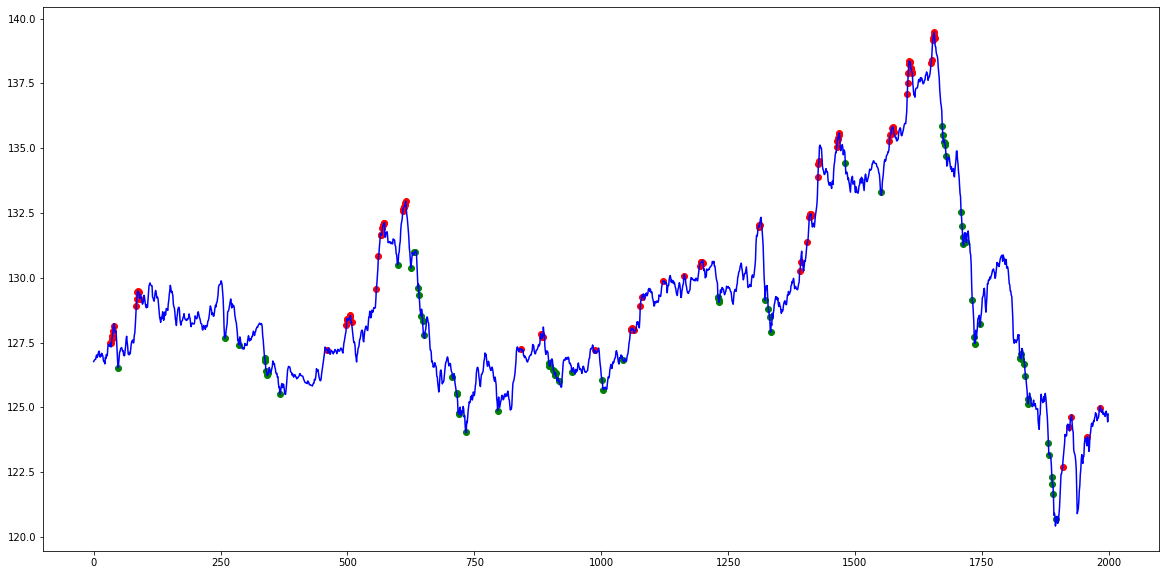

In [22]:
import matplotlib.pyplot as plt
plt.clf()
plt.figure(figsize=(20,10))

# axes = plt.gca()
# axes.set_ylim([0,10000])


plt.scatter(x=first_amnt.index, y=first_amnt['buy'], color='green')
plt.scatter(x=first_amnt.index, y=first_amnt['sell'], color='red')

plt.plot(first_amnt.index, first_amnt['close'], color='blue')
plt.show()